# Carga datos

In [17]:
from pandas.io.stata import StataReader

with StataReader("/content/Latinobarometro_2024_Stata_esp_v20250817.dta") as reader:
    df = reader.read(convert_categoricals=False)
    labels = reader.value_labels()

In [18]:
conversion = {
    3: 2,  # No muy satisfecho
    4: 1,  # Para nada satisfecho
    2: 3,  # Bastante satisfecho
    1: 4   # Muy satisfecho
}


# Reemplazar valores en la columna P1ST
df["felicidad"] = df["P1ST"].map(conversion)

/tmp/ipython-input-3763869918.py:10: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["felicidad"] = df["P1ST"].map(conversion)


In [19]:
import numpy as np

# Diccionario de conversión explícita
conversion = {
    "derecha": 10,
    "izquierda": 0,
    "Ninguno": np.nan,
    "No contesta": np.nan,
    "No sabe": np.nan,
    97: np.nan,
    99: np.nan,
    "97": np.nan,
    "99": np.nan
}

def convertir(val):
    # Si el valor está en el diccionario, usarlo
    if val in conversion:
        return conversion[val]

    # Si es numérico y no es 97/99, devolverlo tal cual
    try:
        # intentar convertir a número
        num = float(val)
        # si es 97 o 99, poner NaN igual por seguridad
        if num in [97, 99]:
            return np.nan
        return num
    except:
        # cualquier string que no esté en el dict lo dejamos como está
        return val

df["escala"] = df["P16ST"].apply(convertir)

/tmp/ipython-input-3451018561.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["escala"] = df["P16ST"].apply(convertir)


In [20]:
# Interés en la política (1=Muy interesado ... 4=Nada interesado) → invertimos para que valores altos = más interés
df["interes_politica"] = df["P36STGBS"].replace({1:4, 2:3, 3:2, 4:1})

# Sentimiento partidario (1=Sí, 2=No)
df["identificacion_partidaria"] = df["P38STGBS"].replace({1:1, 2:0})

# Representación política (1=Sí, 2=No)
df["representacion"] = df["P25ST"].replace({1:1, 2:0})

# Eficacia política (P26ST: 1=cree que su voto hace diferencia, 2=no)
df["eficacia_voto"] = df["P26ST"].replace({1:1, 2:0})

# Polarización
df["polarizacion_continua"] = abs(df["escala"] - 5)

# === 4. Seleccionar columnas relevantes ===
vars_modelo = [
    "felicidad",
    "polarizacion_continua",
    "interes_politica",
    "identificacion_partidaria",
    "representacion",
    "eficacia_voto",

]

# === 5. Tabla descriptiva básica ===
tabla = df[vars_modelo].describe().T
tabla["n_miss"] = df[vars_modelo].isna().sum()
tabla["%_miss"] = (tabla["n_miss"] / len(df) * 100).round(1)

tabla

/tmp/ipython-input-3852682124.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["interes_politica"] = df["P36STGBS"].replace({1:4, 2:3, 3:2, 4:1})
/tmp/ipython-input-3852682124.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df["identificacion_partidaria"] = df["P38STGBS"].replace({1:1, 2:0})
/tmp/ipython-input-3852682124.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.co

,count,mean,std,min,25%,50%,75%,max,n_miss,%_miss
felicidad,19067.0,3.151256,0.836020,1.0,3.0,3.0,4.0,4.0,147,0.8
polarizacion_continua,16832.0,2.458175,2.034877,0.0,0.0,2.0,5.0,5.0,2382,12.4
interes_politica,19044.0,2.047311,0.986022,1.0,1.0,2.0,3.0,4.0,170,0.9
identificacion_partidaria,18918.0,0.338778,0.473307,0.0,0.0,0.0,1.0,1.0,296,1.5
representacion,18467.0,0.225592,0.417983,0.0,0.0,0.0,0.0,1.0,747,3.9
eficacia_voto,18507.0,0.648457,0.477465,0.0,0.0,1.0,1.0,1.0,707,3.7


In [21]:
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Seleccionamos las variables que van al modelo
vars_modelo = [
    "felicidad",
    "polarizacion_continua",
    "interes_politica",
    "identificacion_partidaria",
    "representacion",
    "eficacia_voto",
]

# Copia del DataFrame (opcional)
df_sem = df[vars_modelo].copy()

# Estandarización (solo columnas numéricas)
scaler = StandardScaler()
df_sem_z = pd.DataFrame(
    scaler.fit_transform(df_sem),
    columns=[col + "_z" for col in df_sem.columns],
    index=df_sem.index
)

# Unimos al df original (por si querés comparar)
df = pd.concat([df, df_sem_z], axis=1)

# Comprobamos
df_sem_z.describe().T

,count,mean,std,min,25%,50%,75%,max
felicidad_z,19067.0,-1.490623e-18,1.000026,-2.573280,-0.180929,-0.180929,1.015247,1.015247
polarizacion_continua_z,16832.0,-7.767340e-17,1.000030,-1.208057,-1.208057,-0.225168,1.249167,1.249167
interes_politica_z,19044.0,-1.179014e-16,1.000026,-1.062186,-1.062186,-0.047983,0.966219,1.980421
identificacion_partidaria_z,18918.0,-2.403781e-17,1.000026,-0.715787,-0.715787,-0.715787,1.397064,1.397064
representacion_z,18467.0,3.001155e-17,1.000027,-0.539730,-0.539730,-0.539730,-0.539730,1.852779
eficacia_voto_z,18507.0,-9.521511e-17,1.000027,-1.358162,-1.358162,0.736289,0.736289,0.736289


#SEM

In [22]:
%%capture
!pip install semopy

In [23]:
from semopy import Model, semplot
import pandas as pd

# Definición del modelo SEM
model_desc = """
# Variables latentes
Engagement =~ interes_politica_z + eficacia_voto_z + representacion_z
Polarization =~ polarizacion_continua_z + identificacion_partidaria_z

# Relaciones estructurales
felicidad_z ~ Engagement + Polarization
"""

# Crear el modelo
model = Model(model_desc)

# Ajustar (usa FIML por defecto para manejar NaN)
model.fit(df)

# Resumen de resultados
resumen = model.inspect()
resumen

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,interes_politica_z,~,Engagement,1.000000,-,-,-
1,eficacia_voto_z,~,Engagement,0.550435,0.019067,28.868176,0.0
2,representacion_z,~,Engagement,0.854926,0.022879,37.366738,0.0
3,polarizacion_continua_z,~,Polarization,1.000000,-,-,-
4,identificacion_partidaria_z,~,Polarization,4.584940,0.378674,12.107889,0.0
5,felicidad_z,~,Engagement,0.295065,0.03158,9.343515,0.0
6,felicidad_z,~,Polarization,-0.467087,0.072928,-6.404772,0.0
7,Engagement,~~,Engagement,0.324815,0.011406,28.476481,0.0
8,Polarization,~~,Polarization,0.040089,0.004183,9.583838,0.0
9,Polarization,~~,Engagement,0.071020,0.006041,11.757003,0.0


In [24]:
from semopy import calc_stats

stats = calc_stats(model)
stats

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,7,15,270.163288,0.0,6676.946958,0.960498,0.959538,0.913296,0.959538,0.915352,0.044235,27.971878,138.059401,0.014061


# Con controles

In [25]:
import pandas as pd
import numpy as np

# === 1. Revisión rápida de las columnas ===
cols_check = ["EDAD", "SEXO", "S11", "S5", "S30"]

# === 2. Conversiones ===
##################################################################
# Edad: asegurar numérico
df["edad"] = pd.to_numeric(df["EDAD"], errors="coerce")

##################################################################
# Género: 1 = hombre, 2 = mujer → 0/1
df["genero"] = df["SEXO"].replace({1: 0, 2: 1})

##################################################################
# Educación: usar S16 (1 = sin estudios ... 14 = universidad)
# Paso 1: convertir a numérico
df["educacion_num"] = pd.to_numeric(df["S11"], errors="coerce")

# Paso 2: definir el escalador manual
def escalar_educacion(x):
    if pd.isna(x):
        return np.nan
    if x == 1:
        return 0  # sin estudios
    elif 2 <= x <= 13:
        return x - 1  # años reales (1–12)
    elif x == 14:  # universitario incompleto
        return 14
    elif x == 15:  # universitario completo
        return 16
    elif x == 16:  # técnico incompleto
        return 13
    elif x == 17:  # técnico completo
        return 14
    else:
        return np.nan

df["educacion"] = df["educacion_num"].apply(escalar_educacion)

##################################################################
# El salario o el sueldo que Ud percibe, les permite...
df["S5_num"] = pd.to_numeric(df["S5"], errors="coerce")

# Paso 2: diccionario de conversión
conv_s5 = {
    1: 4,  # les alcanza bien → muy buena situación
    2: 3,  # les alcanza justo
    3: 2,  # no les alcanza
    4: 1,  # no les alcanza, grandes dificultades
    2147483622: np.nan,  # no sabe
    2147483623: np.nan   # no contesta
}

# Paso 3: aplicar conversión
df["econ"] = df["S5_num"].replace(conv_s5)

##################################################################
# Edad al cuadrado
df["edad2"]=df["edad"]**2


##################################################################
# ¿Cómo calificaría en general la situación económica actual del país? Diría Ud. que es...?
# Paso 1: convertir P6 a numérico
df["P6_num"] = pd.to_numeric(df["P6STGBS"], errors="coerce")

# Paso 2: diccionario de conversión
# Invertimos la escala para que valores altos = percepción económica más positiva
conv_p6 = {
    1: 5,  # muy buena  → muy positiva
    2: 4,  # buena
    3: 3,  # regular
    4: 2,  # mala
    5: 1,  # muy mala → muy negativa
    2147483622: np.nan,  # no sabe
    2147483623: np.nan   # no contesta
}

# Paso 3: aplicar conversión
df["econ_pais"] = df["P6_num"].replace(conv_p6)



##################################################################
# P10STGBS. Hablando en general, ¿Diría Ud. que se puede confiar en la mayoría de las personas o que uno nunca es lo suficientemente cuidadoso en el trato con los demás?
df["P10_num"] = pd.to_numeric(df["P10STGBS"], errors="coerce")
conv_p10 = {
    1: 1,  # Se puede confiar en la mayoría
    2: 0,  # Uno nunca es suficientemente cuidadoso
    2147483622: np.nan,  # no sabe
    2147483623: np.nan   # no contesta
}

# Paso 3: aplicar conversión
df["confianza"] = df["P10_num"].replace(conv_p10)



#####################################################################
conv_p18 = {
    1: 4,  # muy de acuerdo
    2: 3,  # acuerdo
    3: 2,  # desacuerdo
    4: 1,  # muy en desacuerdo
    0: np.nan,  # no sabe
    2147483622: np.nan,  # no sabe
    2147483623: np.nan   # no contesta
}
df['por_encima']=df["P18ST.C"].replace(conv_p18)

# === 3. Resumen estadístico ===
vars_control = ["felicidad","interes_politica","eficacia_voto","polarizacion_continua","identificacion_partidaria","edad", "genero", "educacion", "econ", "edad2", "econ_pais", "confianza", "por_encima"]
tabla_controles = df[vars_control].describe().T
tabla_controles["n_miss"] = df[vars_control].isna().sum()
tabla_controles["%_miss"] = (tabla_controles["n_miss"] / len(df) * 100).round(1)

tabla_controles

,count,mean,std,min,25%,50%,75%,max,n_miss,%_miss
felicidad,19067.0,3.151256,0.836020,1.0,3.0,3.0,4.0,4.0,147,0.8
interes_politica,19044.0,2.047311,0.986022,1.0,1.0,2.0,3.0,4.0,170,0.9
eficacia_voto,18507.0,0.648457,0.477465,0.0,0.0,1.0,1.0,1.0,707,3.7
polarizacion_continua,16832.0,2.458175,2.034877,0.0,0.0,2.0,5.0,5.0,2382,12.4
identificacion_partidaria,18918.0,0.338778,0.473307,0.0,0.0,0.0,1.0,1.0,296,1.5
edad,19214.0,41.772666,16.815096,16.0,27.0,40.0,55.0,98.0,0,0.0
genero,19214.0,0.517331,0.499713,0.0,0.0,1.0,1.0,1.0,0,0.0
educacion,19214.0,9.828719,4.482466,0.0,6.0,11.0,14.0,16.0,0,0.0
econ,18893.0,2.668607,0.856411,1.0,2.0,3.0,3.0,4.0,321,1.7
edad2,19214.0,2027.688352,1562.030112,256.0,729.0,1600.0,3025.0,9604.0,0,0.0


In [ ]:
import pandas as pd
import numpy as np

vars_control = ["felicidad","interes_politica","eficacia_voto",
                "polarizacion_continua","identificacion_partidaria",
                "edad","genero","educacion","econ",
                "edad2","econ_pais","confianza"]

tabla_controles = df[vars_control].describe().T
tabla_controles["n_miss"] = df[vars_control].isna().sum()
tabla_controles["%_miss"] = (tabla_controles["n_miss"] / len(df) * 100).round(1)

# Renombrar columnas para paper + consistencia visual
tabla_compacta = tabla_controles[["count","mean","std","min","max"]].rename(
    columns={
        "count": "N",
        "mean": "Media",
        "std": "DE",
        "min": "Mín",
        "max": "Máx"
    }
)

# Generar LaTeX prolijo y compacto
latex_table = tabla_compacta.to_latex(
    index=True,
    float_format="%.2f",
    column_format="lrrrrrrr",
    caption="Estadísticas descriptivas de variables",
    label="tab:descriptivos_compactos",
    bold_rows=False,
    escape=True
)

# Guardar archivo
with open("descriptivas.tex", "w", encoding="utf-8") as f:
    f.write(latex_table)

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
for var in ["edad", "educacion", "econ", "edad2", "econ_pais", "confianza", "por_encima"]:
    df[var + "_z"] = scaler.fit_transform(df[[var]])

In [27]:
model_desc = """
Engagement =~ interes_politica_z + eficacia_voto_z + representacion_z
Polarization =~ polarizacion_continua_z + identificacion_partidaria_z + por_encima_z
felicidad_z ~ Engagement + Polarization + edad_z + edad2_z + genero + educacion_z + econ_z + econ_pais_z + confianza_z
"""

# Crear el modelo
model = Model(model_desc)

# Ajustar (usa FIML por defecto para manejar NaN)
model.fit(df)

# Resumen de resultados
resumen = model.inspect()
resumen

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,interes_politica_z,~,Engagement,1.000000,-,-,-
1,eficacia_voto_z,~,Engagement,0.542411,0.019048,28.475397,0.0
2,representacion_z,~,Engagement,0.850384,0.023008,36.960283,0.0
3,polarizacion_continua_z,~,Polarization,1.000000,-,-,-
4,identificacion_partidaria_z,~,Polarization,4.444322,0.349745,12.707307,0.0
5,por_encima_z,~,Polarization,0.210756,0.039685,5.310656,0.0
6,felicidad_z,~,Engagement,0.106711,0.027746,3.846046,0.00012
7,felicidad_z,~,Polarization,-0.177415,0.065043,-2.727641,0.006379
8,felicidad_z,~,edad_z,-0.084014,0.038177,-2.200637,0.027762
9,felicidad_z,~,edad2_z,0.024710,0.038216,0.646605,0.517888


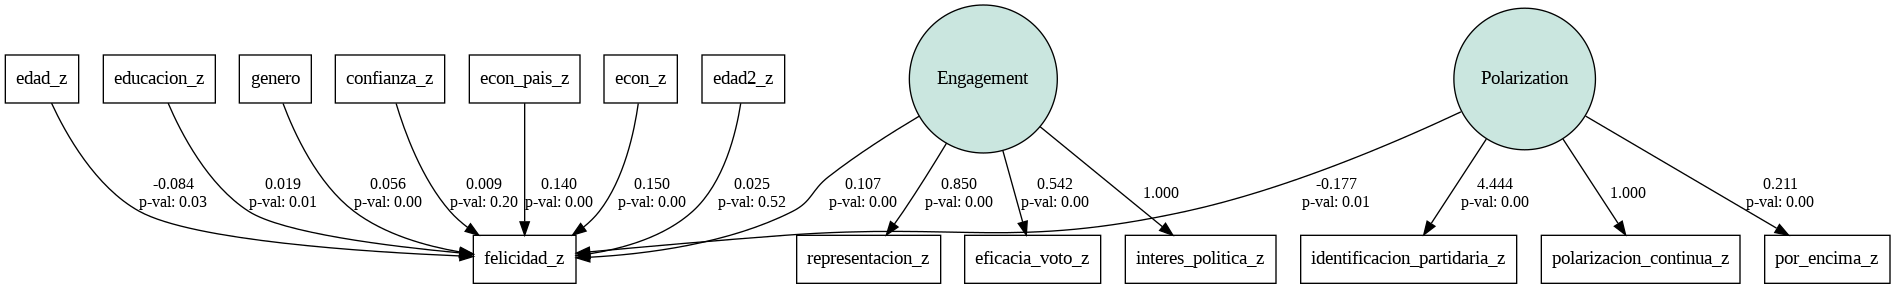

In [28]:
from IPython.display import Image
semplot(model, "diagrama_sem.png")
Image("diagrama_sem.png")